In [1]:
import sys
import os
import importlib
from   pathlib      import Path
import traceback

import numpy                as np
import matplotlib           as mpl
import matplotlib.pyplot    as plt
import seaborn              as sns
import pandas               as pd

from scipy.stats    import kruskal, wilcoxon, mannwhitneyu, ranksums
from scipy.optimize import curve_fit
from lmfit import Model, Parameters

from eidynamics     import utils, plot_tools
from eidynamics     import pattern_index

sns.set_context('paper')
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 16
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['lines.linewidth'] = 2
%matplotlib widget
%tb

# make a colour map viridis
viridis = mpl.colormaps["viridis"]
flare   = mpl.colormaps["flare_r"]
crest   = mpl.colormaps["crest_r"]
magma   = mpl.colormaps["magma"]
edge    = mpl.colormaps['edge']
rocket_r    = mpl.colormaps['rocket_r']

color_E = flare
color_I = crest
color_freq = {1:magma(0.05), 5:magma(0.1), 10:magma(0.2), 20:magma(.4), 30:magma(.5), 40:magma(.6), 50:magma(.7), 100:magma(.9)}
color_squares = {1:viridis(0.2), 5:viridis(.4), 7:viridis(.6), 15:viridis(.8), 20:viridis(1.0)}
color_squares_r = {1:rocket_r(0.2), 5:rocket_r(.4), 7:rocket_r(.6), 15:rocket_r(.8), 20:rocket_r(1.0)}
color_EI = {-70:flare(0), 0:crest(0)}
color_cells = mpl.colormaps['tab10']
Fs = 2e4

freq_sweep_pulses = np.arange(9)

No traceback available to show.


In [2]:
def sdnfunc(expected, gamma):
    return gamma * expected / (gamma + expected)

def nosdn(expected, m):
    return m * expected

In [ ]:
figure_raw_material_location = Path(r"\\storage.ncbs.res.in\adityaa\Lab\Projects\EI_Dynamics\Analysis\paper_figure_matter")
paper_figure_export_location = Path(r"\\storage.ncbs.res.in\adityaa\Lab\Projects\EI_Dynamics\Analysis\paper_figures\submission")
data_path_FS                 = Path(r"\\storage.ncbs.res.in\adityaa\Lab\Projects\EI_Dynamics\Analysis\parsed_data\Jan_2025\FreqSweep")
data_path_LTM                = Path(r"\\storage.ncbs.res.in\adityaa\Lab\Projects\EI_Dynamics\Analysis\parsed_data\Jan_2025\LTMRand")
data_path_grid               = Path(r"\\storage.ncbs.res.in\adityaa\Lab\Projects\EI_Dynamics\Analysis\parsed_data\Jan_2025\Grid")
data_path_analysed           = Path(r"\\storage.ncbs.res.in\adityaa\Lab\Projects\EI_Dynamics\Analysis\parsed_data\Jan_2025\second_order")

### Load the CC data and screen

In [5]:
# short data path that contains the kernel fit data for FreqSweep protocol, also contains the field p2p data. latest and checked. Use this for all freqsweep measurements.
# Contains screening parameters also.
# 18Sep24
CC_FS_shortdf_withkernelfit_datapath = data_path_FS / "all_cells_FreqSweep_CC_kernelfit_response_measurements.h5"
cc_FS_shortdf = pd.read_hdf(CC_FS_shortdf_withkernelfit_datapath, key='data')
print(cc_FS_shortdf.shape)

CC_LTM_shortdf_withkernelfit_datapath = data_path_LTM / "all_cells_LTM_CC_kernelfit_response_measurements_noNANs.h5"
cc_LTM_shortdf = pd.read_hdf(CC_LTM_shortdf_withkernelfit_datapath, key='data')
print(cc_LTM_shortdf.shape)

cc_FS_LTM_shortdf = pd.concat([cc_FS_shortdf, cc_LTM_shortdf], axis=0, ignore_index=True)
# reset index
cc_FS_LTM_shortdf.reset_index(drop=True, inplace=True)

(4971, 163)
(539, 163)


In [6]:
# Data screening
# CC data screening based on dataflag_fields: protocol freqsweep
cc_FS_LTM_shortdf_slice = cc_FS_LTM_shortdf[
                                            (cc_FS_LTM_shortdf['location'] == 'CA1') &
                                            (cc_FS_LTM_shortdf['numSq'].isin([1,5,7,15])) &
                                            (cc_FS_LTM_shortdf['stimFreq'].isin([20,30,40,50])) &
                                            (cc_FS_LTM_shortdf['condition'] == 'Control') &
                                            (cc_FS_LTM_shortdf['ch0_response']==1) &
                                            (cc_FS_LTM_shortdf['IR'] >50) & (cc_FS_LTM_shortdf['IR'] < 400) &
                                            (cc_FS_LTM_shortdf['tau'] < 40) & 
                                            # (cc_FS_LTM_shortdf['probePulseStart']==0.2) &
                                            # (cc_FS_LTM_shortdf['intensity']==100) &
                                            # (cc_FS_LTM_shortdf['pulseWidth']==2) &
                                            (cc_FS_LTM_shortdf['spike_in_baseline_period'] == 0) &
                                            (cc_FS_LTM_shortdf['ac_noise_power_in_ch0'] < 40)
                                            ]
print(cc_FS_LTM_shortdf.shape, '--screened-->', cc_FS_LTM_shortdf_slice.shape)
screened_cc_trialIDs = cc_FS_LTM_shortdf_slice['trialID'].unique()

# save trial IDs as a numpy array text file, all trialID are strings
np.savetxt(paper_figure_export_location / "Figure3_screened_trialIDs_CC_FS_LTM.txt", screened_cc_trialIDs, fmt='%s')

cc_FS_LTM_shortdf_slice['patternList'] = cc_FS_LTM_shortdf_slice['patternList'].astype('int32')
patternIDs = np.sort( cc_FS_LTM_shortdf_slice[cc_FS_LTM_shortdf_slice['numSq'] != 1]['patternList'].unique() )

print(f"Unique cells in screened data: { cc_FS_LTM_shortdf_slice['cellID'].nunique()}")
print(f"Unique sweeps in screened data: {cc_FS_LTM_shortdf_slice['trialID'].nunique()}")

# # take list stored in "peaks_field_norm" column and make it into new columns
cc_FS_LTM_shortdf_slice = utils.expand_list_column(cc_FS_LTM_shortdf_slice, 'peaks_field_norm', 'pfn_')

(5510, 163) --screened--> (3426, 163)
Unique cells in screened data: 22
Unique sweeps in screened data: 3426
input df shape:  (3426, 163) num of new columns:  9
new columns:  ['pfn_0', 'pfn_1', 'pfn_2', 'pfn_3', 'pfn_4', 'pfn_5', 'pfn_6', 'pfn_7', 'pfn_8'] 3426 9
(3426, 9) (3426, 172)


C:\Users\Aditya\AppData\Local\Temp\ipykernel_27992\512037211.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc_FS_LTM_shortdf_slice['patternList'] = cc_FS_LTM_shortdf_slice['patternList'].astype('int32')


## Load the VC data and screen

In [7]:
VC_FS_shortdf_withkernelfit_datapath = data_path_FS / "all_cells_FreqSweep_VC_kernelfit_response_measurements.h5"
vc_FS_shortdf = pd.read_hdf(VC_FS_shortdf_withkernelfit_datapath, key='data')
print(vc_FS_shortdf.shape)

# save df
vc_FS_shortdf.to_hdf(VC_FS_shortdf_withkernelfit_datapath, key='data', mode='w')
# VC data screening
# VC data screening based on dataflag_fields
vc_FS_shortdf_slice = vc_FS_shortdf[
            (vc_FS_shortdf['location'] == 'CA1') &
            (vc_FS_shortdf['numSq'].isin([1,5,15])) &
            (vc_FS_shortdf['stimFreq'].isin([20,30,40,50])) &
            (vc_FS_shortdf['condition'] == 'Control') &
            (vc_FS_shortdf['ch0_response']==1) &
            # (vc_FS_shortdf['intensity'] == 100) &
            # (vc_FS_shortdf['pulseWidth'] == 2) &
            # (vc_FS_shortdf['probePulseStart']==0.2) &
            (vc_FS_shortdf['IR'] >40) & (vc_FS_shortdf['IR'] < 400) &
            (vc_FS_shortdf['tau'] < 40) & 
            (vc_FS_shortdf['ac_noise_power_in_ch0'] < 40)&
            (vc_FS_shortdf['valley_0'].notnull())
        ]
print(vc_FS_shortdf.shape, '--screened-->', vc_FS_shortdf_slice.shape)
screened_vc_trialIDs = vc_FS_shortdf_slice['trialID'].unique()
np.savetxt(paper_figure_export_location / "Figure3_screened_trialIDs_VC_FS.txt", screened_vc_trialIDs, fmt='%s')

print(f"Unique cells in screened data: { vc_FS_shortdf_slice['cellID'].nunique()}")
print(f"Unique sweeps in screened data: {vc_FS_shortdf_slice['trialID'].nunique()}")

# take list stored in "peaks_field_norm" column and make it into new columns
# vc_FS_shortdf_slice = utils.expand_list_column(vc_FS_shortdf_slice, 'pulseTimes', 'stimOnset_')

(4407, 163)


C:\Users\Aditya\AppData\Local\Temp\ipykernel_27992\892675109.py:6: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['sex', 'unit', 'location', 'protocol', 'numSq', 'clampMode',
       'condition', 'numPatterns', 'frameChangeTimes', 'pulseTimes',
       'fieldData', 'peaks_cell', 'peaks_cell_norm', 'auc_cell', 'slope_cell',
       'delay_cell', 'peaks_field', 'peaks_field_norm', 'cell_fpr',
       'field_fpr', 'cell_ppr', 'cell_stpr', 'field_ppr', 'field_stpr',
       'trialID', 'cellunit', 'fieldunit'],
      dtype='object')]

  vc_FS_shortdf.to_hdf(VC_FS_shortdf_withkernelfit_datapath, key='data', mode='w')


(4407, 163) --screened--> (2245, 163)
Unique cells in screened data: 14
Unique sweeps in screened data: 2245


In [8]:
def calculate_expected_response(celldf, pulse_index, freq, patternID,):
    """
    Calculate the expected response of a pattern based on the response to individual spots in the pattern
    """
    from eidynamics import pattern_index
    # constants
    Fs      = 2e4
    cellID  = celldf['cellID'].iloc[0]
    
    # checks
    field_data=True if celldf['numChannels'].iloc[0] == 4 else False

    # check if the given cell has 1sq data
    if not 1 in celldf['numSq'].unique():
        # print('No 1Sq data for this cell', celldf['numSq'].unique())
        # generate dataerror to be caught by the calling function
        raise ValueError(f'Cell: {cellID} - No 1Sq data for this cell. {pulse_index}, {freq}, {patternID}')
    # data
    pattern_response_df             = celldf[(celldf['patternList'] == patternID) & (celldf['stimFreq'] == freq)  ]
    if pattern_response_df.shape[0] == 0:
        raise ValueError(f'Cell: {cellID} - No data for this pattern {patternID} and freq {freq} Hz')
    
    # get the pattern
    constituent_spots_of_pattern    = pattern_index.get_patternIDlist_for_nSq_pattern(patternID) #1sq spots that make the pattern in the patternID
    numSq                           = len(constituent_spots_of_pattern)

    obs_col = 'PSC_' + str(pulse_index)
    obs_col_field = 'pfn_' + str(pulse_index)

    # # slice the dataframe to get the response to the given pattern
    celldf                          = celldf.loc[:, ~celldf.columns.isin(celldf.columns[28:49])]
    celldf.loc[:, 'patternList']    = celldf['patternList'].astype('int32')
    
    # step 0: get the observed response from the pattern_response_df
    observed_response_cell      = pattern_response_df.loc[:, obs_col].values
    if field_data:
        observed_response_field     = pattern_response_df.loc[:, obs_col_field].values
        observed_response_scaled    = observed_response_cell / observed_response_field
    else:
        observed_response_scaled    = observed_response_cell * np.nan
    
    # expected response calculation
    # step 1: slice the dataframe to get only those rows where 'patternList' is in the list 'constituent_spots_of_pattern'
    df1sq = celldf.loc[celldf['patternList'].isin(constituent_spots_of_pattern), :].copy()
    
    # step 2: get the peaks for each row between columns probePulseStart and probePulseStart+ipi
    # here i am taking the mean of all the trials of the constituent patterns and then summing those means
    expected_response = df1sq.loc[:,('patternList','PSC_0')].groupby(by='patternList').mean().sum()['PSC_0']
    
    return numSq, freq, patternID, pulse_index, field_data, observed_response_cell, observed_response_scaled, expected_response

## Load SDN and fit data

In [9]:
sdn_df = pd.read_hdf(paper_figure_export_location / "Figure3_sdn_data_FS_LTM.h5", key='data')
print(sdn_df.shape)

fitdf = pd.read_hdf(paper_figure_export_location / "Figure3_gamma_and_slope_fits_FS_LTM.h5", key='data')
print(fitdf.shape)

(9315, 9)
(922, 10)


In [10]:
cc_delay_df = pd.read_hdf(paper_figure_export_location / "Figure3_delay_df_CC_FS.h5", key='data')
vc_delay_df = pd.read_hdf(paper_figure_export_location / "Figure3_delay_df_VC_FS.h5", key='data')
ebyi_df_norm     = pd.read_hdf(    paper_figure_export_location / "Figure3_ebyi_df_VC_FS_norm.h5" , key='data')
ebyi_df_raw     = pd.read_hdf(    paper_figure_export_location / "Figure3_ebyi_df_VC_FS_raw.h5" , key='data')

## Or recalcualte SDN and fit data

In [10]:
# sdn_data = []

# for cell in np.sort(cc_FS_LTM_shortdf_slice['cellID'].unique()):
#     for patternID in patternIDs:
#         for freq in [20, 30, 40, 50]:
#             celldf = cc_FS_LTM_shortdf_slice[(cc_FS_LTM_shortdf_slice['cellID'] == cell)]
#             for pulse_index in freq_sweep_pulses:
#                 try:
#                     x = calculate_expected_response(celldf, pulse_index, freq, patternID)
#                     numSq, freq, patternID, pulse_index, field_data, observed_response, observed_response_scaled, expected_response = x
#                     for obs, obs_sc in zip(observed_response, observed_response_scaled):
#                         AP = 1 if obs > 20 else 0
#                         # print(f'AP detected in {cell}, {numSq}, {patternID}, {freq}, {pulse_index}') if obs > 20 else ''
#                         sdn_data.append({
#                                         'cellID':   cell,
#                                         'numSq':    numSq,
#                                         'stimFreq': freq,
#                                         'patternID':patternID,
#                                         'pulse':    pulse_index,
#                                         'obs':      obs,
#                                         'obs_scaled':obs_sc,
#                                         'exp':      expected_response,
#                                         'AP':       AP,
#                                         })
#                 except ValueError as e:
#                     print(e)
#                     continue

# # convert the list of dicts into a dataframe
# sdn_df = pd.DataFrame(sdn_data)
# sdn_df.to_hdf(paper_figure_export_location / "Figure3_sdn_data_FS_LTM.h5", key='data')
# print(sdn_df.shape)

In [11]:
def sdn_fits(xdata, ydata, f,s,t):
    # # if xdata and ydata lenghts are not same, 
    if len(xdata) != len(ydata):
        raise ValueError('Length of xdata and ydata are not same')
        return np.nan, np.nan, np.nan, np.nan
        
    # if xdata or yadata is empty or have length 0, 
    if len(xdata) <3 or len(ydata) <3:
        return np.nan, np.nan, np.nan, np.nan
        
    # Create an lmfit model for the sdnfunc
    model = Model(sdnfunc)
    # Create a set of parameters
    params = Parameters()
    params.add('gamma', value=5)

    # Create an lmfit model for the data
    model_linear = Model(nosdn)
    # Create a set of parameters
    params_linear = Parameters()
    params_linear.add('m', value=1)

    # Fit the sdnfunc to  data using lmfit and method = cobyla
    result = model.fit(ydata, params, observed=xdata, method='cobyla')

    # also try fitting xdata and ydata to a linear model
    result_linear = model_linear.fit(ydata, params_linear, observed=xdata, method='cobyla')

    # Extract the fitted parameters
    fitted_gamma = np.round( result.best_values['gamma'], 3)
    fitted_slope = np.round( result_linear.best_values['m'], 3)

    return fitted_gamma, fitted_slope, result.rsquared, result_linear.rsquared

def gamma_distribution(df_sdn, fitdf=None, x='expected_response', y='observed_response', first='cellID', second='pulse_index', third='freq'):
    gamma_dist = []

    # get gamma distribution for the entire dataset
    dfslice = df_sdn.dropna(subset=[x,y])
    g,m,r2g,r2lin = sdn_fits(dfslice[x], dfslice[y], 'all','all','all')
    gamma_dist.append({'expected': x, 'observed':y, first:1000, second:1000, third:1000, 'sample_size':dfslice.shape[0], 'gamma':g, 'slope':m, 'r2_sdn':r2g, 'r2_lin':r2lin})
    f,s,t = np.nan, np.nan, np.nan

    for f in np.sort(df_sdn[first].unique()):
        dfslice = df_sdn[(df_sdn[first] == f)]
        # remove nan and inf from data
        dfslice = dfslice[(np.abs(dfslice[x]) != np.inf) & (np.abs(dfslice[y]) != np.inf)].dropna(subset=[x,y])
        # if most of x and y data is 0, the model will not converge, so we need to remove all zero entries
        dfslice = dfslice[(dfslice[x] != 0) & (dfslice[y] != 0)]
        
        g,m,r2g,r2lin = sdn_fits(dfslice[x], dfslice[y], f,'all','all')
        gamma_dist.append({'expected': x, 'observed':y, first:f, second:1000, third:1000, 'sample_size':dfslice.shape[0], 'gamma':g, 'slope':m, 'r2_sdn':r2g, 'r2_lin':r2lin})
        
        for s in np.sort(df_sdn[second].unique()):
            dfslice = df_sdn[(df_sdn[first] == f) & (df_sdn[second] == s)].dropna(subset=[x,y])
            # remove np.inf from data
            dfslice = dfslice[(np.abs(dfslice[x]) != np.inf) & (np.abs(dfslice[y]) != np.inf)].dropna(subset=[x,y])
            # if most of x and y data is 0, the model will not converge, so we need to remove all zero entries
            dfslice = dfslice[(dfslice[x] != 0) & (dfslice[y] != 0)]
            
            g,m,r2g,r2lin = sdn_fits(dfslice[x], dfslice[y], f,s,'all')
            gamma_dist.append({'expected': x, 'observed':y, first:f, second:s, third:1000, 'sample_size':dfslice.shape[0], 'gamma':g, 'slope':m, 'r2_sdn':r2g, 'r2_lin':r2lin})
            
            for t in np.sort(df_sdn[third].unique()):
                dfslice = df_sdn[(df_sdn[first] == f) & (df_sdn[second] == s) & (df_sdn[third] == t)].dropna(subset=[x,y])
                # remove nan
                # remove np.inf from data
                dfslice = dfslice[(np.abs(dfslice[x]) != np.inf) & (np.abs(dfslice[y]) != np.inf)].dropna(subset=[x,y])
                # if most of x and y data is 0, the model will not converge, so we need to remove all zero entries
                dfslice = dfslice[(dfslice[x] != 0) & (dfslice[y] != 0)]
                g,m,r2g,r2lin = sdn_fits(dfslice[x], dfslice[y], f,s,t)
                gamma_dist.append({'expected': x, 'observed':y, first:f, second:s, third:t, 'sample_size':dfslice.shape[0], 'gamma':g, 'slope':m, 'r2_sdn':r2g, 'r2_lin':r2lin})


    # create a dataframe from the list of dicts
    df_gamma_dist = pd.DataFrame(gamma_dist)

    if fitdf is not None:
        fitdf2 = pd.concat([fitdf, df_gamma_dist], axis=0)
    else:
        fitdf2 = df_gamma_dist

    return fitdf2

### generate gamma and slope fits for the whole dataset

In [12]:
# fitdf_temp = gamma_distribution(sdn_df[(sdn_df['AP']==0)], sdndf=None,        x='exp', y='obs',        first='cellID', second='pulse', third='stimFreq')   
# fitdf      = gamma_distribution(sdn_df[(sdn_df['AP']==0)], sdndf=fitdf_temp,  x='exp', y='obs_scaled', first='cellID', second='pulse', third='stimFreq') 

# print(fitdf.shape)
# # save fitdf
# fitdf.to_hdf(paper_figure_export_location / "Figure3_gamma_and_slope_fits_FS_LTM.h5", key='data')

# Fig 3

In [13]:
def generate_ebyi_df(vc_shortdf):
    idvars = ['cellID','clampPotential','stimFreq','numSq','patternList','pulseWidth','intensity','trialID']
    valvars = [f'PSC_{i}' for i in freq_sweep_pulses]
    df2 = vc_shortdf.melt(id_vars=idvars, 
                value_vars=valvars, 
                var_name='pulse', value_name='PSC')

    # if clampPotential=-70, remove rows with positive PSC values
    df2 = df2[((df2['clampPotential']==-70) & (df2['PSC']<0)) | ((df2['clampPotential']==0) & (df2['PSC']>0))]

    df2['pulse'] = df2['pulse'].apply(lambda x: int(x.split('_')[-1]))
    df2 = df2.dropna(subset=['PSC'])
    df2.drop(columns=['trialID'], inplace=True)
    df2['numSq'] = df2['numSq'].astype('int')
    df4 = df2.groupby(['cellID','clampPotential','stimFreq','numSq','patternList','pulseWidth','intensity','pulse']).mean().reset_index()
    ebyi_df = df4.pivot(index=['cellID','stimFreq','numSq','patternList','pulseWidth','intensity','pulse'], columns='clampPotential', values='PSC').reset_index()
    ebyi_df = ebyi_df.dropna(subset=[-70,0])
    # ratio of -70 and 0
    ebyi_df['EbyI'] = ( - ebyi_df[-70] / ebyi_df[0])
    # ebyi_df = ebyi_df[(ebyi_df['EbyI'] < 20) & (ebyi_df['EbyI'] > 0)]

    print(ebyi_df.shape)
    return ebyi_df

### fig 3v9

C:\Users\Aditya\AppData\Local\Temp\ipykernel_27992\1530798817.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ebyi_df_norm_filt.rename(columns={-70:'Exc', 0:'Inh'}, inplace=True)
C:\Users\Aditya\AppData\Local\Temp\ipykernel_27992\1530798817.py:95: UserWarning: 
The sizes list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  ax3['E'] = sns.scatterplot(data=dftemp, x='exp', y='obs', hue='numSq', size='numSq',sizes=[150], ax=ax3['E'], palette=color_squares)


[3.85347148] [0.29472188] [0.00913653] [-0.76242031]


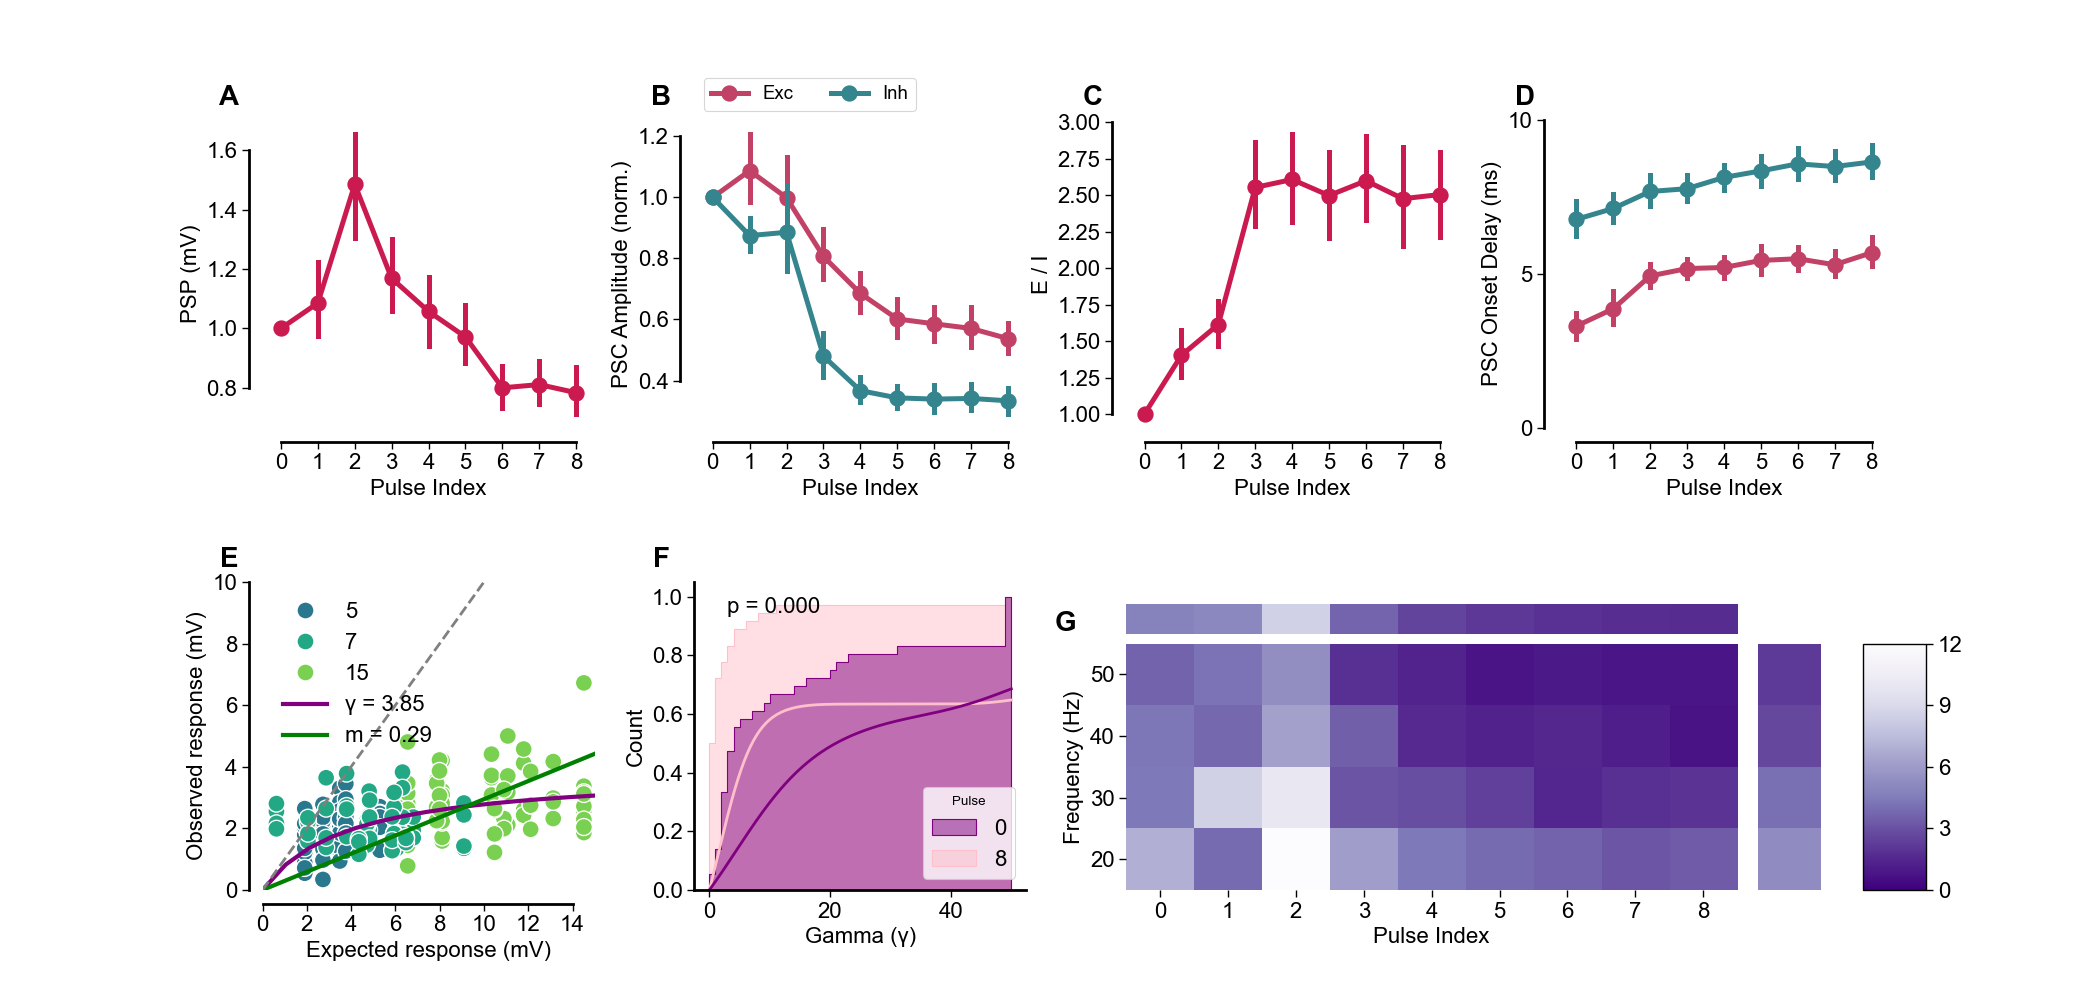

In [ ]:
plt.close('all')
figsize=(21,10)
Fig3, ax3 = plt.subplot_mosaic([['A','B','C','D'],['E','F','G','G']], figsize=figsize,)
plt.subplots_adjust(wspace=0.3, hspace=0.5)

color_pulses_lin   = mpl.colormaps['Greens']
color_pulses_gamma = mpl.colormaps['Purples']

# drop all rows where gamma is nan
fitdf_slice = fitdf[~fitdf['gamma'].isna()]
selected_cell = 3402


# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# ############ Voltage clamp plots #################
# E by I ratio vs pulse index across frequencies
ax3['A'].text(-0.1, 1.05, 'A', fontweight='bold', fontsize=20, ha='center', transform=ax3['A'].transAxes)
cc_delay_df_filt = cc_delay_df[(cc_delay_df['numSq']>1) & (cc_delay_df['stimFreq']==20)]
# sns.violinplot(data=cc_delay_df_filt, x='pulse', y='peak_PSP', ax=ax3['A'], color=rocket_r(0.5), )
sns.pointplot(data=cc_delay_df_filt, x='pulse', y='peak_PSP', ax=ax3['A'], color=rocket_r(0.5), errorbar='ci',)
# run a kruskal wallis test across the pulsewise responses
pulsewise_responses = cc_delay_df_filt.pivot_table(columns='pulse', index='trialID', values='peak_PSP', )
# now run KW test across columns
kw_res = kruskal(*[pulsewise_responses[col] for col in pulsewise_responses.columns])
# ax3['A'].set_ylim([0, 1.5])
# ax3['A'].set_yticks([0,0.5,1.0,1.5])
ax3['A'].legend([],[], frameon=False)
ax3['A'].set_ylabel('PSP (mV)', fontsize=16)
ax3['A'].set_xlabel('Pulse Index', fontsize=16)
sns.despine(ax=ax3['A'], top=True, right=True, offset=10, trim=True)

ebyi_df_norm_filt = ebyi_df_norm[(ebyi_df_norm['numSq']>1)]
# rename columns -70 and 0 to Exc and Inh
ebyi_df_norm_filt.rename(columns={-70:'Exc', 0:'Inh'}, inplace=True)

# pivot ebyi_df_norm_filt to get Exc and Inh values into a single column
ebyi_df_norm_filt_long = ebyi_df_norm_filt.melt(id_vars=['cellID','stimFreq','numSq','patternList','pulseWidth','intensity','pulse'], value_vars=['Exc','Inh'], var_name='clampPotential', value_name='PSC')

ax3['B'].text(-0.1, 1.05, 'B', fontweight='bold', fontsize=20, ha='center', transform=ax3['B'].transAxes)
# sns.violinplot(data=ebyi_df_norm_filt_long[(ebyi_df_norm_filt_long['stimFreq']==20)], x='pulse', y='PSC', hue='clampPotential', ax=ax3['B'], split=True, palette=[flare(0.5), crest(0.5)], )
sns.pointplot(data=ebyi_df_norm_filt, x='pulse', y='Exc', ax=ax3['B'], color=flare(0.5), errorbar='ci', label='Exc')
sns.pointplot(data=ebyi_df_norm_filt, x='pulse', y='Inh', ax=ax3['B'], color=crest(0.5), errorbar='ci', label='Inh' )
# ax3['B'].set_ylim([0,1.5])
# ax3['B'].set_yticks([0,0.5,1.0,1.5])
ax3['B'].legend(loc='lower left', ncols=4, fontsize='small', bbox_to_anchor=(0.0, 1.0))
ax3['B'].set_ylabel('PSC Amplitude (norm.)', fontsize=16)
ax3['B'].set_xlabel('Pulse Index', fontsize=16)
sns.despine(ax=ax3['B'], top=True, right=True, offset=10, trim=True)

ax3['C'].text(-0.1, 1.05, 'C', fontweight='bold', fontsize=20, ha='center', transform=ax3['C'].transAxes)
# sns.violinplot(data=ebyi_df_norm_filt, x='pulse', y='EbyI', ax=ax3['C'], palette=color_freq, hue='stimFreq', hue_order=[20,50])
sns.pointplot(data=ebyi_df_norm_filt, x='pulse', y='EbyI', ax=ax3['C'], color=rocket_r(0.5), errorbar='ci',)
# ax3['C'].set_ylim([0, 3])
# ax3['C'].set_yticks(np.arange(0,3.1,1))
ax3['C'].legend([],[], frameon=False)
ax3['C'].set_ylabel('E / I', fontsize=16)
ax3['C'].set_xlabel('Pulse Index', fontsize=16)
sns.despine(ax=ax3['C'], top=True, right=True, offset=10, trim=True)

### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
vc_delay_df_filt = vc_delay_df[(vc_delay_df['numSq']>1) ]

ax3['D'].text(-0.1, 1.05, 'D', fontweight='bold', fontsize=20, ha='center', transform=ax3['D'].transAxes)
vc_delay_df_filt = vc_delay_df_filt[(vc_delay_df_filt['numSq']>1)]
# pivot ebyi_df_norm_filt to get Exc and Inh values into a single column
vc_peakdelay_df_filt_long  = vc_delay_df_filt.melt(id_vars=['cellID','stimFreq','numSq','patternList','pulseWidth','intensity','pulse'], value_vars=['exc_peak','inh_peak'], var_name='clampPotential', value_name='peak_delay')
vc_onsetdelay_df_filt_long = vc_delay_df_filt.melt(id_vars=['cellID','stimFreq','numSq','patternList','pulseWidth','intensity','pulse'], value_vars=['exc_onset','inh_onset'], var_name='clampPotential', value_name='onset_delay')

# sns.violinplot(data=vc_onsetdelay_df_filt_long, x='pulse', y='onset_delay', hue='clampPotential', ax=ax3['D'], split=True, palette=[flare(0.5), crest(0.5)], )
sns.pointplot(data=vc_delay_df_filt, x='pulse', y='exc_onset', ax=ax3['D'], color=flare(0.5), errorbar='ci',)
sns.pointplot(data=vc_delay_df_filt, x='pulse', y='inh_onset', ax=ax3['D'], color=crest(0.5), errorbar='ci',)
ax3['D'].set_xticks( np.arange(0,9))
ax3['D'].set_yticks( np.arange(0,11,5))
ax3['D'].set_xlabel('Pulse Index', fontsize=16)
ax3['D'].set_ylabel('PSC Onset Delay (ms)')
ax3['D'].legend([],[], frameon=False)
# ax3['D'].legend( loc='lower left', ncols=4, fontsize='small', bbox_to_anchor=(0.0, 0.0))
[ax3['D'].spines[place].set_visible(False) for place in ['top', 'right', ] ]
sns.despine(ax=ax3['D'], offset=10, trim=True)

# sns.violinplot(data=vc_delay_df_filt, x='pulse', y='onset_delayEI', ax=ax3['D'], palette=color_freq, hue='stimFreq', hue_order=[20,50])
# sns.pointplot(data=vc_delay_df_filt, x='pulse', y='onset_delayEI', ax=ax3['D'], color=rocket_r(0.5), errorbar='ci',)
# # ax3['D'].set_ylim([-0.5,5])
# # ax3['D'].set_yticks([0,2,4])
# ax3['D'].legend([],[], frameon=False)
# ax3['D'].set_ylabel('Onset Delay (E-I) (ms)', fontsize=16)
# ax3['D'].set_xlabel('Pulse Index', fontsize=16)
# sns.despine(ax=ax3['D'], top=True, right=True, offset=10, trim=True)

### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### ------------SDN Plots--------------------------------------------------------------------------------------------------------------------------------------------
# Plot 3D: Scatterplot and SDN for cell = selected_cell, pulse = 0
ax3['E'].text(-0.1, 1.05, 'E', fontweight='bold', fontsize=20, ha='center', transform=ax3['E'].transAxes)
dftemp = sdn_df[(sdn_df['cellID']==selected_cell) & (sdn_df['pulse']==0) & (sdn_df['AP']==0)]
ax3['E'] = sns.scatterplot(data=dftemp, x='exp', y='obs', hue='numSq', size='numSq',sizes=[150], ax=ax3['E'], palette=color_squares)
# add gamma fit for 0th pule and all frequencies
gammatemp       = fitdf_slice[(fitdf_slice['cellID']==selected_cell)&(fitdf_slice['observed']=='obs')&(fitdf_slice['pulse']==0)&(fitdf_slice['stimFreq']==1000)]['gamma'].values
slopetemp       = fitdf_slice[(fitdf_slice['cellID']==selected_cell)&(fitdf_slice['observed']=='obs')&(fitdf_slice['pulse']==0)&(fitdf_slice['stimFreq']==1000)]['slope'].values
r2_gammatemp    = fitdf_slice[(fitdf_slice['cellID']==selected_cell)&(fitdf_slice['observed']=='obs')&(fitdf_slice['pulse']==0)&(fitdf_slice['stimFreq']==1000)]['r2_sdn'].values
r2_slopetemp    = fitdf_slice[(fitdf_slice['cellID']==selected_cell)&(fitdf_slice['observed']=='obs')&(fitdf_slice['pulse']==0)&(fitdf_slice['stimFreq']==1000)]['r2_lin'].values
print(gammatemp, slopetemp, r2_gammatemp, r2_slopetemp)
ax3['E'].plot(np.linspace(0,20,20), sdnfunc(np.linspace(0,20,20),gammatemp), color='purple', linewidth=3, label=f'γ = {gammatemp[0]:.2f}')
ax3['E'].plot(np.linspace(0,20,20), nosdn(np.linspace(0,20,20),slopetemp),   color='green', linewidth=3,    label=f'm = {slopetemp[0]:.2f}')
ax3['E'].plot([0,15],[0,15], color='grey', linestyle='--')

ax3['E'].set_xlabel('Expected response (mV)')
ax3['E'].set_ylabel('Observed response (mV)')
ax3['E'].legend(loc='upper left', fontsize=16, frameon=False)

ax3['E'].set_xlim([0,15])
ax3['E'].set_ylim([0,10])
sns.despine(bottom=False, left=False, trim=True, offset=10, ax=ax3['E'])

# ### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # # Plot 3F: lineplot of gamma across all cells, where x-axis: pulse, y-axis: gamma, hue: stim_freq
# ax3['F' ].text(-0.1, 1.05, 'F',  fontweight='bold', fontsize=20, ha='center', transform=ax3['F'].transAxes)

# for i,f in enumerate([20,30,40,50]):
#     gammas = []
#     slopes = []
#     for p in range(9):
#         dftemp = sdn_df[(sdn_df['cellID']==selected_cell) & (sdn_df['pulse']==p)& (sdn_df['stimFreq']==f)]
#         if dftemp.shape[0] == 0:
#             continue
#         gammatemp = fitdf_slice[(fitdf_slice['cellID']==selected_cell)&(fitdf_slice['observed']=='obs')&(fitdf_slice['pulse']==p)&(fitdf_slice['stimFreq']==f)]['gamma'].values
#         slopetemp = fitdf_slice[(fitdf_slice['cellID']==selected_cell)&(fitdf_slice['observed']=='obs')&(fitdf_slice['pulse']==p)&(fitdf_slice['stimFreq']==f)]['slope'].values
#         gammas.append(gammatemp)
#         slopes.append(slopetemp)

#     ax3['F' ].plot(np.arange(9), np.array(gammas), color='purple', linewidth=3, label=f'γ ({f} Hz)', alpha=0.2+i*0.2)

#     # set ylim
#     ax3['F'].set_ylim( [0, 10])

#     sns.despine(bottom=False, left=False, ax=ax3['F'],  trim=True, offset=10)

#     # legend outside
#     ax3['F'].legend( bbox_to_anchor=(0.0, 0.8),  loc='lower left')

#     ax3['F'].set_xlabel('Pulse index', fontdict={'fontsize':12})
#     ax3['F'].set_ylabel('Gamma (γ)', fontdict={'fontsize':12})


### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Histogram of gamma values for all the cells in the control condition
ax3['F'].text( -0.1, 1.05, 'F', fontweight='bold', fontsize=20, ha='center', transform=ax3['F'].transAxes)

gammadist0 = fitdf[(fitdf['cellID']!=1000) &(fitdf['pulse']==0) & (fitdf['stimFreq']!=1000)& (fitdf['observed']=='obs')& (fitdf['sample_size']!=0)].dropna(subset=['gamma','slope'])
gammadist8 = fitdf[(fitdf['cellID']!=1000) &(fitdf['pulse']==8) & (fitdf['stimFreq']!=1000)& (fitdf['observed']=='obs')& (fitdf['sample_size']!=0)].dropna(subset=['gamma','slope'])
# any gamma value above 100 can be capped at 100
cap = 50
gammadist0['gamma'] = gammadist0['gamma'].apply(lambda x: cap if x>cap else x)
gammadist8['gamma'] = gammadist8['gamma'].apply(lambda x: cap if x>cap else x)

# combine the two gammadist dataframes
gammadist0['pulse'] = 0
gammadist8['pulse'] = 8
gammadist = pd.concat([gammadist0, gammadist8], axis=0)

axf = sns.histplot(data=gammadist, x='gamma', hue='pulse', palette={0:'purple',8:'pink'}, kde=True, ax=ax3['F'], alpha=0.5, line_kws={'lw': 2,}, binwidth=1, element='step', cumulative=True, stat="density", common_norm=False, legend=True)
# sns.histplot(data=gammadist8, x='gamma', color='#a61900', kde=True, ax=ax3['F'], alpha=0.5, label='Pulse 8', line_kws={'lw': 2,}, binwidth=1, element='step')
sns.move_legend(ax3['F'], "lower right", bbox_to_anchor=(1,0), title='Pulse', fontsize=16)

# add a vertical line at gammma = 10 and slope = 1
# ax3['F'].axvline(10, color='black', linestyle='--')

ax3['F'].set_xlabel('Gamma (γ)', fontsize=16)
ax3['F'].set_ylabel('Count', fontsize=16)
sns.despine(bottom=False, left=False, ax=ax3['F'])
ax3['F'].tick_params(axis='both', which='major', labelsize=16)

# statistics on gamma and slope
# rank-order test to check if pulse 0 and pulse 8 distributions are different
_, pval_gamma = mannwhitneyu(gammadist0['slope'], gammadist8['slope'])
_, pval_slope = mannwhitneyu(gammadist0['slope'], gammadist8['slope'])

# stat annotate on the plot
ax3['F'].text(0.1,0.9, f'p = {pval_gamma:.3f}', transform=ax3['F'].transAxes, fontsize=16, color='black')


# ### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Plot 3G: Heatmap of slope
fitdf_slice = fitdf[(fitdf['cellID']!=1000) & (fitdf['pulse']!=1000) & (fitdf['stimFreq']!=1000)& (fitdf['observed']=='obs')& (fitdf['sample_size']!=0)].dropna(subset=['gamma','slope'])

fitdf_slice.drop(columns=['expected','observed','cellID'], inplace=True)
x = fitdf_slice.groupby(['pulse', 'stimFreq']).median().reset_index()
n = fitdf_slice.groupby(['pulse', 'stimFreq']).count().reset_index()
gammapivot = x.pivot(index='stimFreq', columns='pulse', values='gamma')
gammapivot_n = n.pivot(index='stimFreq', columns='pulse', values='gamma')
slopepivot = x.pivot(index='stimFreq', columns='pulse', values='slope')
slopepivot_n = n.pivot(index='stimFreq', columns='pulse', values='slope')
ax3['G'], _, _, _, _ = plot_tools.ax_to_partial_dist_heatmap_ax(gammapivot, gammapivot_n, Fig3, ax3['G'], barw=0.03, pad=0.01, shrink=0.8, palette='Purples_r', minmax=[0,12], force_vmin_to_zero=True, annotate=False)
ax3['G'].text( -0.1, 1.05, 'G', fontweight='bold', fontsize=20, ha='center', transform=ax3['G'].transAxes)

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
for a in ax3.keys():
    ax3[a].tick_params(axis='both', which='major', labelsize=16)
    # axis label fontsize
    ax3[a].set_xlabel(ax3[a].get_xlabel(), fontsize=16)
    ax3[a].set_ylabel(ax3[a].get_ylabel(), fontsize=16)
    # spine width
    ax3[a].spines['left'].set_linewidth(2)
    ax3[a].spines['bottom'].set_linewidth(2)

# Fig3.tight_layout()
## save fig 3
Fig3.savefig(paper_figure_export_location / 'Figure3.png', dpi=300, bbox_inches='tight')
Fig3.savefig(paper_figure_export_location / 'Figure3.svg', dpi=300, bbox_inches='tight')
Fig3.savefig(paper_figure_export_location / 'Figure3.pdf', dpi=300, bbox_inches='tight')

In [60]:
### Extended Data Figure 2

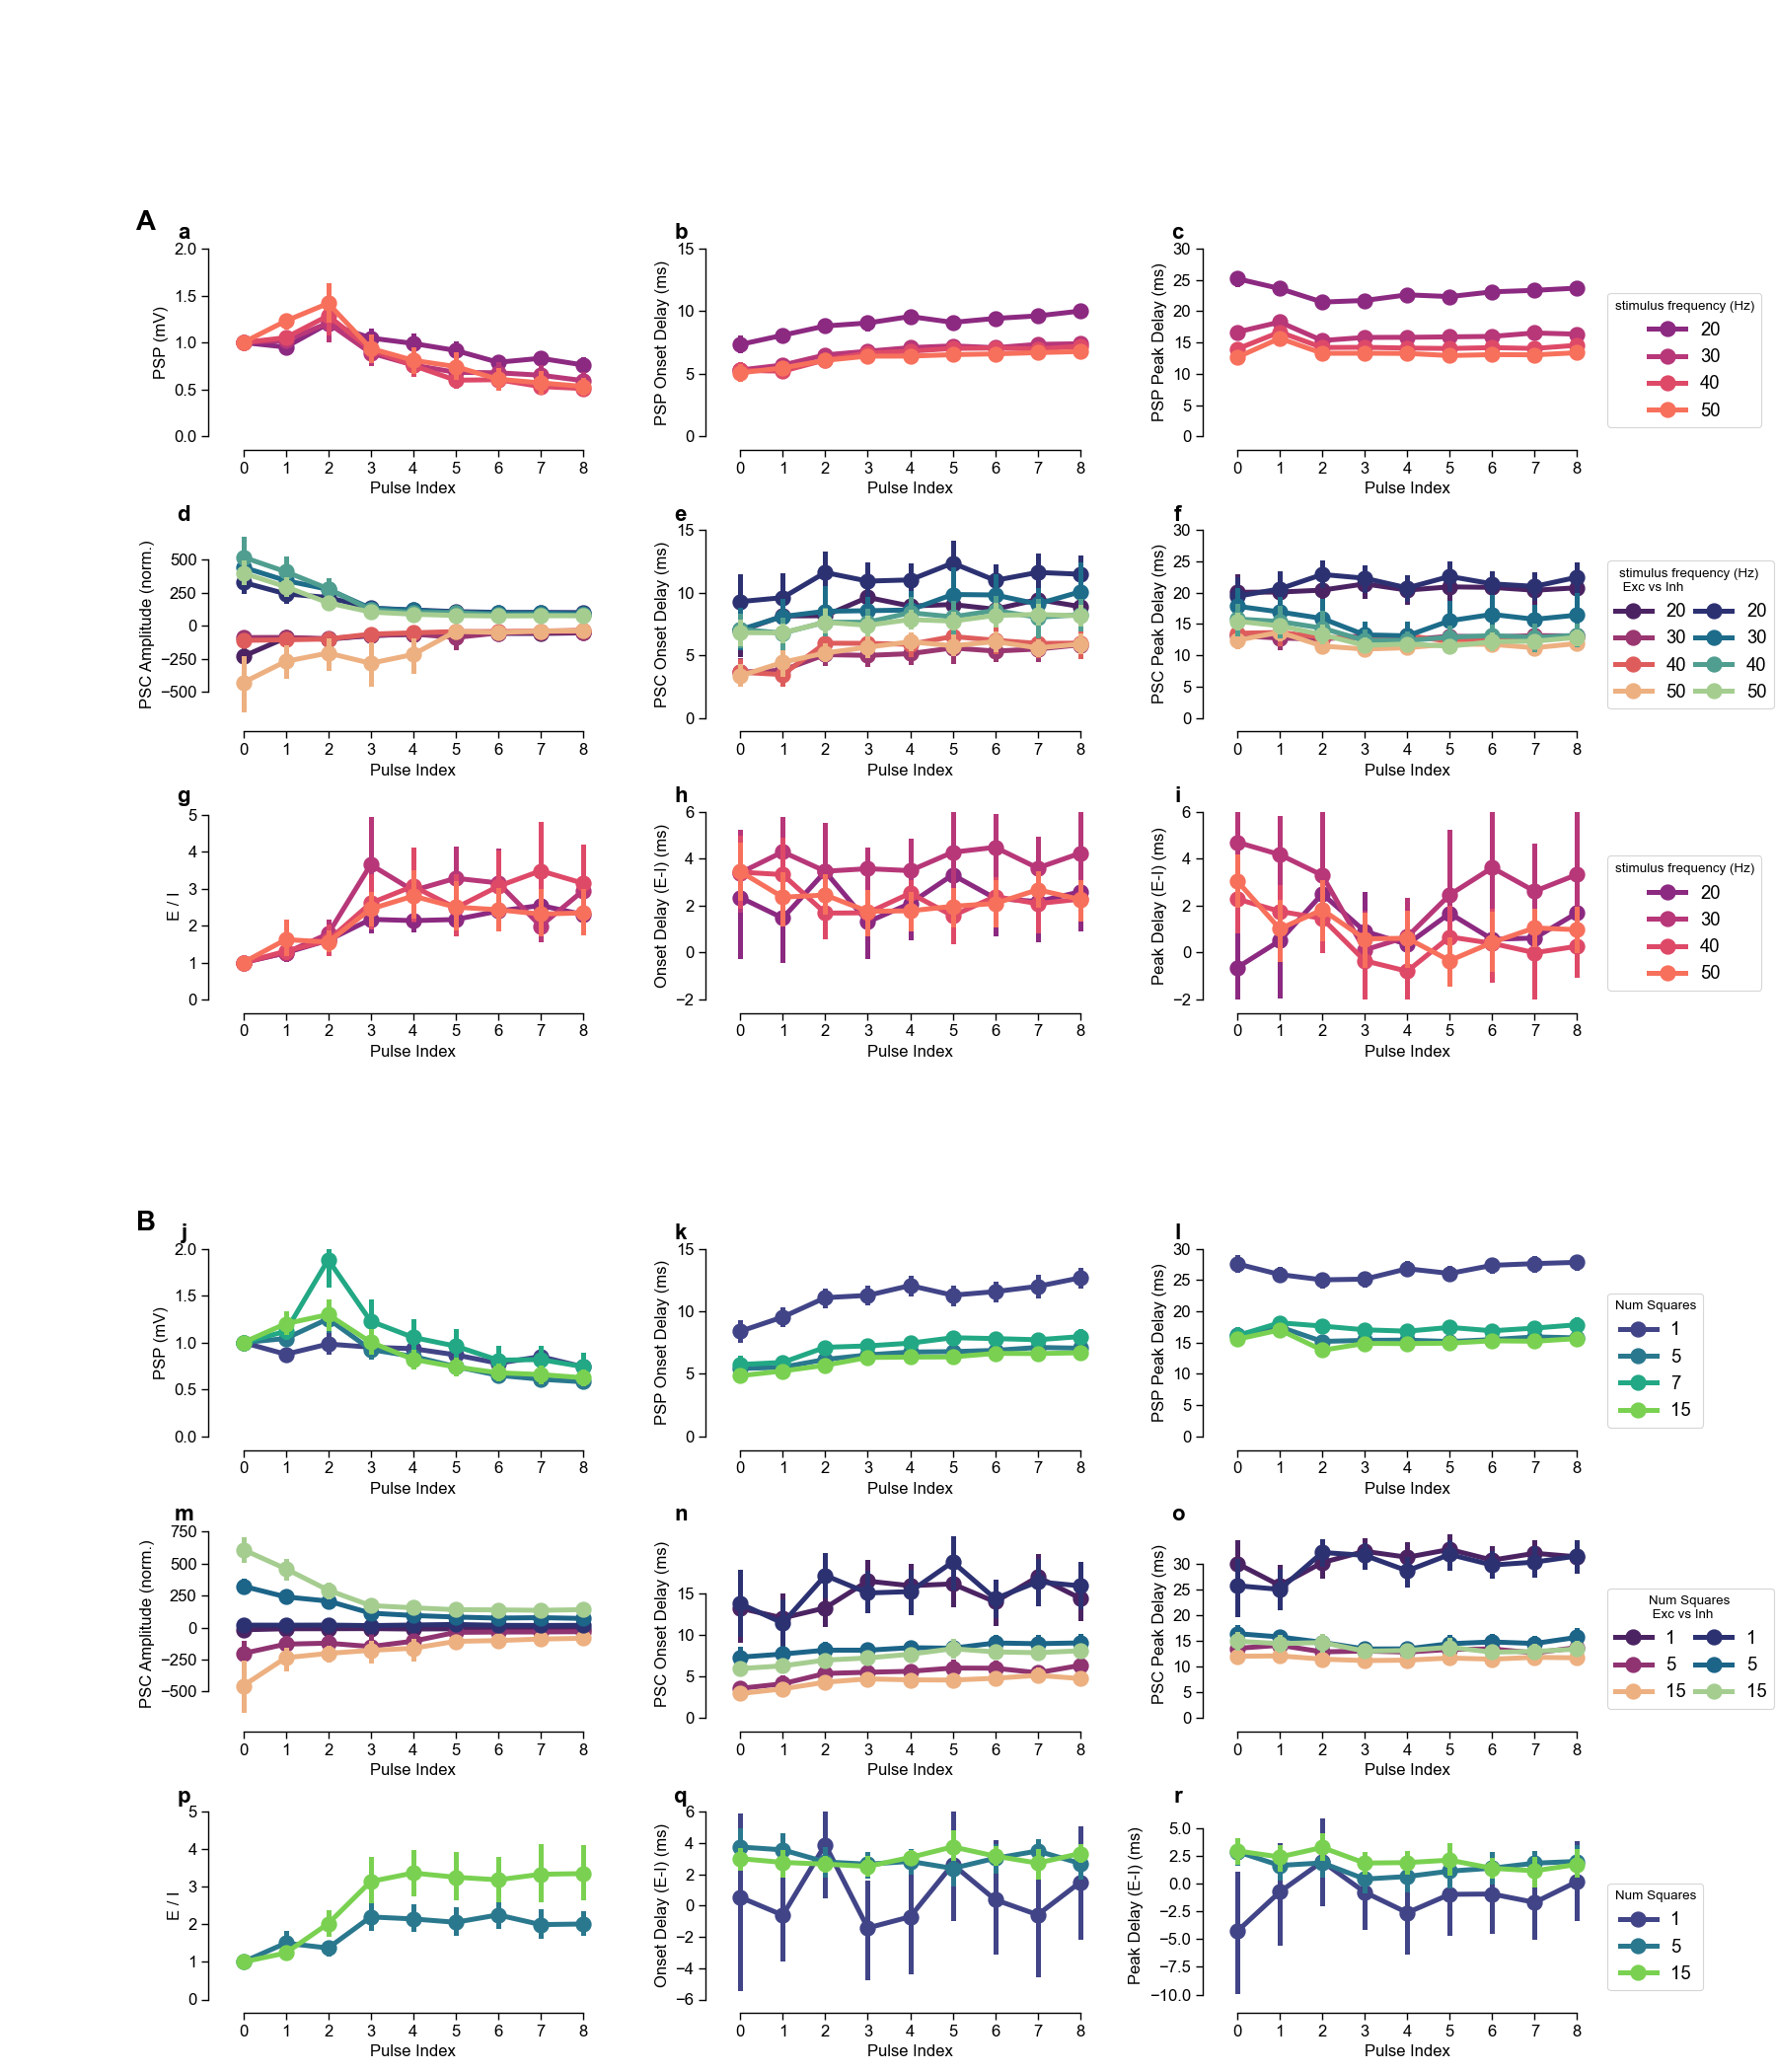

In [59]:
Fig3, ax3 = plt.subplot_mosaic([['a','b','c'],['d','e','f'],['g','h','i'],['j','k','l'],['m','n','o'],['p','q','r']], figsize=(18,21),)

plt.subplots_adjust(wspace=0.3, hspace=0.5)

color_pulses_lin   = mpl.colormaps['Greens']
color_pulses_gamma = mpl.colormaps['Purples']

# drop all rows where gamma is nan
fitdf_slice = fitdf[~fitdf['gamma'].isna()]
selected_cell = 3402

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# ############ Voltage clamp plots #################
# E by I ratio vs pulse index across frequencies
ax3['a'].text(-0.1, 1.05, 'a', fontweight='bold', fontsize=16, ha='center', transform=ax3['a'].transAxes)
sns.pointplot(data=cc_delay_df, x='pulse', y='peak_PSP', hue='stimFreq', ax=ax3['a'], palette=color_freq, errorbar='ci',)
# run a kruskal wallis test across the pulsewise responses
pulsewise_responses = cc_delay_df.pivot_table(columns='pulse', index='trialID', values='peak_PSP', )
# now run KW test across columns
kw_res = kruskal(*[pulsewise_responses[col] for col in pulsewise_responses.columns])
ax3['a'].set_ylim([0, 2])
ax3['a'].set_yticks([0,0.5,1.0,1.5,2.0])
ax3['a'].set_ylabel('PSP (mV)', fontsize=12)
ax3['a'].set_xlabel('Pulse Index', fontsize=12)
ax3['a'].legend([],[], frameon=False)
sns.despine(ax=ax3['a'], top=True, right=True, offset=10, trim=True)

ax3['d'].text(-0.1, 1.05, 'd', fontweight='bold', fontsize=16, ha='center', transform=ax3['d'].transAxes)
sns.pointplot(data=ebyi_df_raw, x='pulse', hue='stimFreq', y=-70, ax=ax3['d'], palette=color_E, errorbar='ci', )
sns.pointplot(data=ebyi_df_raw, x='pulse', hue='stimFreq', y = 0, ax=ax3['d'], palette=color_I, errorbar='ci',  )
# ax3['d'].set_ylim([0,1.5])
# ax3['d'].set_yticks([0,0.5,1.0,1.5])
ax3['d'].set_ylabel('PSC Amplitude (norm.)', fontsize=12)
ax3['d'].set_xlabel('Pulse Index', fontsize=12)
ax3['d'].legend([],[], frameon=False)
sns.despine(ax=ax3['d'], top=True, right=True, offset=10, trim=True)

ax3['g'].text(-0.1, 1.05, 'g', fontweight='bold', fontsize=16, ha='center', transform=ax3['g'].transAxes)
sns.pointplot(data=ebyi_df_norm_filt, x='pulse', y='EbyI', ax=ax3['g'], hue='stimFreq', palette=color_freq, errorbar='ci',)
# ax3['g'].set_ylim([0, 5])
ax3['g'].set_yticks(np.arange(0,5.1,1))
ax3['g'].set_ylabel('E / I', fontsize=12)
ax3['g'].set_xlabel('Pulse Index', fontsize=12)
sns.despine(ax=ax3['g'], top=True, right=True, offset=10, trim=True)
# legend outside
ax3['g'].legend( [],[], frameon=False)

### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

ax3['b'].text(-0.1, 1.05, 'b', fontweight='bold', fontsize=16, ha='center', transform=ax3['b'].transAxes)
sns.pointplot(data=cc_delay_df, x='pulse', y='onset_delay', ax=ax3['b'], hue='stimFreq', palette=color_freq, errorbar='ci',)
ax3['b'].set_ylim([0, 15])
ax3['b'].set_yticks([0,5,10,15])
ax3['b'].set_ylabel('PSP Onset Delay (ms)', fontsize=12)
ax3['b'].set_xlabel('Pulse Index', fontsize=12)
sns.despine(ax=ax3['b'], top=True, right=True, offset=10, trim=True)
ax3['b'].legend([],[], frameon=False)

ax3['e'].text(-0.1, 1.05, 'e', fontweight='bold', fontsize=16, ha='center', transform=ax3['e'].transAxes)
sns.pointplot(data=vc_delay_df, x='pulse', y='exc_onset', hue='stimFreq', ax=ax3['e'], palette=color_E, errorbar='ci',)
sns.pointplot(data=vc_delay_df, x='pulse', y='inh_onset', hue='stimFreq', ax=ax3['e'], palette=color_I, errorbar='ci',)
ax3['e'].set_xticks( np.arange(0,9))
ax3['e'].set_yticks( np.arange(0,16,5))
ax3['e'].set_xlabel('Pulse Index', fontsize=12)
ax3['e'].set_ylabel('PSC Onset Delay (ms)')
[ax3['e'].spines[place].set_visible(False) for place in ['top', 'right', ] ]
sns.despine(ax=ax3['e'], offset=10, trim=True)
ax3['e'].legend([],[], frameon=False)

ax3['h'].text(-0.1, 1.05, 'h', fontweight='bold', fontsize=16, ha='center', transform=ax3['h'].transAxes)
sns.pointplot(data=vc_delay_df, x='pulse', y='onset_delayEI', hue='stimFreq', ax=ax3['h'], palette=color_freq, errorbar='ci',)
ax3['h'].set_ylim([-2,6])
ax3['h'].set_yticks([-2,0,2,4,6])
ax3['h'].set_ylabel('Onset Delay (E-I) (ms)', fontsize=12)
ax3['h'].set_xlabel('Pulse Index', fontsize=12)
sns.despine(ax=ax3['h'], top=True, right=True, offset=10, trim=True)
ax3['h'].legend( [],[], frameon=False)


# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Voltage clamp plots
# onset delay vs pulse index across frequencies
# E by I ratio vs pulse index across frequencies
ax3['c'].text(-0.1, 1.05, 'c', fontweight='bold', fontsize=16, ha='center', transform=ax3['c'].transAxes)
sns.pointplot(data=cc_delay_df, x='pulse', y='peak_delay', hue='stimFreq', ax=ax3['c'], palette=color_freq, errorbar='ci',)
ax3['c'].set_ylim([0, 30])
ax3['c'].set_yticks(np.arange(0,31,5))
ax3['c'].set_ylabel('PSP Peak Delay (ms)', fontsize=12)
ax3['c'].set_xlabel('Pulse Index', fontsize=12)
sns.despine(ax=ax3['c'], top=True, right=True, offset=10, trim=True)
ax3['c'].legend(loc='lower left', fontsize='small', bbox_to_anchor=(1.0, 0.0), title='stimulus frequency (Hz)')

sns.pointplot(data=vc_delay_df, x='pulse', y='exc_peak', hue='stimFreq', ax=ax3['f'], palette=color_E, errorbar='ci',)
sns.pointplot(data=vc_delay_df, x='pulse', y='inh_peak', hue='stimFreq', ax=ax3['f'], palette=color_I, errorbar='ci',)

ax3['f'].text(-0.1, 1.05, 'f', fontweight='bold', fontsize=16, ha='center', transform=ax3['f'].transAxes)
ax3['f'].legend(loc='lower left', ncols=2, fontsize='small', bbox_to_anchor=(1.0, 0.0), columnspacing=0.5, title='stimulus frequency (Hz) \n Exc vs Inh')
# ax3['f'].set_ylim([0, 20])
ax3['f'].set_xticks( np.arange(0,9))
ax3['f'].set_yticks( np.arange(0,31,5))
ax3['f'].set_xlabel('Pulse Index', fontsize=12)
ax3['f'].set_ylabel('PSC Peak Delay (ms)')
[ax3['f'].spines[place].set_visible(False) for place in ['top', 'right', ] ]
sns.despine(ax=ax3['f'], offset=10, trim=True)

ax3['i'].text(-0.1, 1.05, 'i', fontweight='bold', fontsize=16, ha='center', transform=ax3['i'].transAxes)
sns.pointplot(data=vc_delay_df, x='pulse', y='peak_delayEI', ax=ax3['i'], hue='stimFreq', palette=color_freq, errorbar='ci',)
ax3['i'].set_ylim([-2,6])
ax3['i'].set_yticks([-2,0,2,4,6])
ax3['i'].set_ylabel('Peak Delay (E-I) (ms)', fontsize=12)
ax3['i'].set_xlabel('Pulse Index', fontsize=12)
sns.despine(ax=ax3['i'], top=True, right=True, offset=10, trim=True)
ax3['i'].legend( loc='lower left', fontsize='small', bbox_to_anchor=(1.0, 0.0), title='stimulus frequency (Hz)')

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# numSq plots

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# ############ Voltage clamp plots #################
# E by I ratio vs pulse index across frequencies
ax3['j'].text(-0.1, 1.05, 'j', fontweight='bold', fontsize=16, ha='center', transform=ax3['j'].transAxes)
sns.pointplot(data=cc_delay_df, x='pulse', y='peak_PSP', hue='numSq', ax=ax3['j'], palette=color_squares, errorbar='ci',)
# run a kruskal wallis test across the pulsewise responses
pulsewise_responses = cc_delay_df.pivot_table(columns='pulse', index='trialID', values='peak_PSP', )
# now run KW test across columns
kw_res = kruskal(*[pulsewise_responses[col] for col in pulsewise_responses.columns])
ax3['j'].set_ylim([0, 2])
ax3['j'].set_yticks([0,0.5,1.0,1.5,2.0])
ax3['j'].set_ylabel('PSP (mV)', fontsize=12)
ax3['j'].set_xlabel('Pulse Index', fontsize=12)
sns.despine(ax=ax3['j'], top=True, right=True, offset=10, trim=True)
ax3['j'].legend([],[], frameon=False)

ax3['m'].text(-0.1, 1.05, 'm', fontweight='bold', fontsize=16, ha='center', transform=ax3['m'].transAxes)
sns.pointplot(data=ebyi_df_raw, x='pulse', hue='numSq', y=-70, ax=ax3['m'], palette=color_E, errorbar='ci', )
sns.pointplot(data=ebyi_df_raw, x='pulse', hue='numSq', y = 0, ax=ax3['m'], palette=color_I, errorbar='ci',  )
# ax3['m'].set_ylim([0,1.5])
# ax3['m'].set_yticks([0,0.5,1.0,1.5])
ax3['m'].legend([],[], frameon=False)
ax3['m'].set_ylabel('PSC Amplitude (norm.)', fontsize=12)
ax3['m'].set_xlabel('Pulse Index', fontsize=12)
sns.despine(ax=ax3['m'], top=True, right=True, offset=10, trim=True)

ax3['p'].text(-0.1, 1.05, 'p', fontweight='bold', fontsize=16, ha='center', transform=ax3['p'].transAxes)
sns.pointplot(data=ebyi_df_norm_filt, x='pulse', y='EbyI', ax=ax3['p'], hue='numSq', palette=color_squares, errorbar='ci',)
# ax3['p'].set_ylim([0, 5])
ax3['p'].set_yticks(np.arange(0,5.1,1))
ax3['p'].set_ylabel('E / I', fontsize=12)
ax3['p'].set_xlabel('Pulse Index', fontsize=12)
sns.despine(ax=ax3['p'], top=True, right=True, offset=10, trim=True)
ax3['p'].legend( [],[], frameon=False)

### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

ax3['k'].text(-0.1, 1.05, 'k', fontweight='bold', fontsize=16, ha='center', transform=ax3['k'].transAxes)
sns.pointplot(data=cc_delay_df, x='pulse', y='onset_delay', ax=ax3['k'], hue='numSq', palette=color_squares, errorbar='ci',)
ax3['k'].set_ylim([0, 15])
ax3['k'].set_yticks([0,5,10,15])
ax3['k'].legend([],[], frameon=False)
ax3['k'].set_ylabel('PSP Onset Delay (ms)', fontsize=12)
ax3['k'].set_xlabel('Pulse Index', fontsize=12)
sns.despine(ax=ax3['k'], top=True, right=True, offset=10, trim=True)

ax3['n'].text(-0.1, 1.05, 'n', fontweight='bold', fontsize=16, ha='center', transform=ax3['n'].transAxes)
sns.pointplot(data=vc_delay_df, x='pulse', y='exc_onset', hue='numSq', ax=ax3['n'], palette=color_E, errorbar='ci',)
sns.pointplot(data=vc_delay_df, x='pulse', y='inh_onset', hue='numSq', ax=ax3['n'], palette=color_I, errorbar='ci',)
ax3['n'].set_xticks( np.arange(0,9))
ax3['n'].set_yticks( np.arange(0,16,5))
ax3['n'].set_xlabel('Pulse Index', fontsize=12)
ax3['n'].set_ylabel('PSC Onset Delay (ms)')
[ax3['n'].spines[place].set_visible(False) for place in ['top', 'right', ] ]
sns.despine(ax=ax3['n'], offset=10, trim=True)
ax3['n'].legend( [],[], frameon=False)

ax3['q'].text(-0.1, 1.05, 'q', fontweight='bold', fontsize=16, ha='center', transform=ax3['q'].transAxes)
sns.pointplot(data=vc_delay_df, x='pulse', y='onset_delayEI', hue='numSq', ax=ax3['q'], palette=color_squares, errorbar='ci',)
ax3['q'].set_ylim([-6,6])
ax3['q'].set_yticks([-6,-4,-2,0,2,4,6])
ax3['q'].set_ylabel('Onset Delay (E-I) (ms)', fontsize=12)
ax3['q'].set_xlabel('Pulse Index', fontsize=12)
sns.despine(ax=ax3['q'], top=True, right=True, offset=10, trim=True)
ax3['q'].legend( [],[], frameon=False)


# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Voltage clamp plots
# onset delay vs pulse index across frequencies
# E by I ratio vs pulse index across frequencies
ax3['l'].text(-0.1, 1.05, 'l', fontweight='bold', fontsize=16, ha='center', transform=ax3['l'].transAxes)
sns.pointplot(data=cc_delay_df, x='pulse', y='peak_delay', hue='numSq', ax=ax3['l'], palette=color_squares, errorbar='ci',)
ax3['l'].legend(loc='lower left', fontsize='small', bbox_to_anchor=(1.0, 0.0), title='Num Squares')
ax3['l'].set_ylim([0, 30])
ax3['l'].set_yticks(np.arange(0,31,5))
ax3['l'].set_ylabel('PSP Peak Delay (ms)', fontsize=12)
ax3['l'].set_xlabel('Pulse Index', fontsize=12)
sns.despine(ax=ax3['l'], top=True, right=True, offset=10, trim=True)

sns.pointplot(data=vc_delay_df, x='pulse', y='exc_peak', hue='numSq', ax=ax3['o'], palette=color_E, errorbar='ci',)
sns.pointplot(data=vc_delay_df, x='pulse', y='inh_peak', hue='numSq', ax=ax3['o'], palette=color_I, errorbar='ci',)

ax3['o'].text(-0.1, 1.05, 'o', fontweight='bold', fontsize=16, ha='center', transform=ax3['o'].transAxes)
ax3['o'].legend(loc='lower left', ncols=2, fontsize='small', bbox_to_anchor=(1.0, 0.0), title='Num Squares \n Exc vs Inh', columnspacing=0.5)
# ax3['o'].set_ylim([0, 20])
ax3['o'].set_xticks( np.arange(0,9))
ax3['o'].set_yticks( np.arange(0,31,5))
ax3['o'].set_xlabel('Pulse Index', fontsize=12)
ax3['o'].set_ylabel('PSC Peak Delay (ms)')
[ax3['o'].spines[place].set_visible(False) for place in ['top', 'right', ] ]
sns.despine(ax=ax3['o'], offset=10, trim=True)

ax3['r'].text(-0.1, 1.05, 'r', fontweight='bold', fontsize=16, ha='center', transform=ax3['r'].transAxes)
sns.pointplot(data=vc_delay_df, x='pulse', y='peak_delayEI', ax=ax3['r'], hue='numSq', palette=color_squares, errorbar='ci',)
ax3['r'].legend( loc='lower left', fontsize='small', bbox_to_anchor=(1.0, 0.0), title='Num Squares')
# ax3['r'].set_ylim([-2,6])
# ax3['r'].set_yticks([-2,0,2,4,6])
ax3['r'].set_ylabel('Peak Delay (E-I) (ms)', fontsize=12)
ax3['r'].set_xlabel('Pulse Index', fontsize=12)
sns.despine(ax=ax3['r'], top=True, right=True, offset=10, trim=True)


# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
for a in ax3.keys():
    ax3[a].tick_params(axis='both', which='major', labelsize=12)
    # axis label fontsize
    ax3[a].set_xlabel(ax3[a].get_xlabel(), fontsize=12)
    ax3[a].set_ylabel(ax3[a].get_ylabel(), fontsize=12)
    # spine width
    ax3[a].spines['left'].set_linewidth(1)
    ax3[a].spines['bottom'].set_linewidth(1)

# text label for part A and B
ax3['a'].text(-0.2, 1.1, 'A', fontweight='bold', fontsize=20, ha='center', transform=ax3['a'].transAxes)
ax3['j'].text(-0.2, 1.1, 'B', fontweight='bold', fontsize=20, ha='center', transform=ax3['j'].transAxes)

for a in ['j','k','l','m','n','o','p','q','r']:
    pos = ax3[a].get_position()
    # shift the entire plot to down
    new_pos = [pos.x0, pos.y0-0.075, pos.width, pos.height]
    ax3[a].set_position(new_pos)


## save fig 3
Fig3.savefig(paper_figure_export_location / 'Figure3_extendedData2_stimFreq_numSq.png', dpi=300, bbox_inches='tight')
Fig3.savefig(paper_figure_export_location / 'Figure3_extendedData2_stimFreq_numSq.svg', dpi=300, bbox_inches='tight')
Fig3.savefig(paper_figure_export_location / 'Figure3_extendedData2_stimFreq_numSq.pdf', dpi=300, bbox_inches='tight')